# Assignment 3
## Texture Synthesis

In [1]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import numpy as np
import random
import os.path
import pickle

### Questions 1-5

In [2]:
##############################################################################
#                        Functions for you to complete                       #
##############################################################################

def computeSSD(TODOPatch, TODOMask, textureIm, patchL):
    patch_rows, patch_cols, patch_bands = np.shape(TODOPatch)
    tex_rows, tex_cols, tex_bands = np.shape(textureIm)
    ssd_rows = tex_rows - 2 * patchL
    ssd_cols = tex_cols - 2 * patchL
    SSD = np.zeros((ssd_rows, ssd_cols))
    for r in range(ssd_rows):
        for c in range(ssd_cols):
            # Compute sum square difference between textureIm and TODOPatch
            # for all pixels where TODOMask = 0, and store the result in SSD
            if r < TODOMask.shape[0] and c < TODOMask.shape[1]:
                if TODOMask[r, c] == 0:
                    SSD[r, c] = sum((TODOPatch[r, c, :] * 1.0 - textureIm[r, c, :] * 1.0) ** 2)
    return SSD


def copy_patch(imHole, TODOMask, textureIm, iPatchCenter, jPatchCenter, iMatchCenter, jMatchCenter, patchL, selectPatch):
    patchSize = 2 * patchL + 1
    for i in range(patchSize):
        for j in range(patchSize):
            # Copy the selected patch selectPatch into the image containing
            # the hole imHole for each pixel where TODOMask = 1.
            # The patch is centred on iPatchCenter, jPatchCenter in the image imHole
            if TODOMask[i, j] == 1:
                imHole[i + iPatchCenter - int(patchSize/2), j + jPatchCenter - int(patchSize/2)] = selectPatch[i, j]
    return imHole

In [4]:
##############################################################################
#                            Some helper functions                           #
##############################################################################

def draw_box(im, x1, y1, x2, y2):
    draw = ImageDraw.Draw(im)
    draw.line((x1, y1, x1, y2), fill="white", width=1)
    draw.line((x1, y1, x2, y1), fill="white", width=1)
    draw.line((x2, y2, x1, y2), fill="white", width=1)
    draw.line((x2, y2, x2, y1), fill="white", width=1)
    del draw
    return im


def find_edge(hole_mask):
    [cols, rows] = np.shape(hole_mask)
    edge_mask = np.zeros(np.shape(hole_mask))
    for y in range(rows):
        for x in range(cols):
            if hole_mask[x, y] == 1:
                if (hole_mask[x - 1, y] == 0 or
                        hole_mask[x + 1, y] == 0 or
                        hole_mask[x, y - 1] == 0 or
                        hole_mask[x, y + 1] == 0):
                    edge_mask[x, y] = 1
    return edge_mask

In [10]:
##############################################################################
#                           Main script starts here                          #
##############################################################################

def texture_synthesis(img_path, randomPatchSD, patchL):
    # Constants

    # Change patchL to change the patch size used (patch size is 2 *patchL + 1)
    patchSize = 2 * patchL + 1

    # Display results interactively
    showResults = True

    # Read input image
    im = Image.open(img_path).convert('RGB')
    im_array = np.asarray(im, dtype=np.uint8)
    imRows, imCols, imBands = np.shape(im_array)
    
    # Define hole and texture regions.  This will use files fill_region.pkl and
    # texture_region.pkl, if both exist, otherwise user has to select the regions.
    imname = os.path.splitext(os.path.basename(img_path))[0]
    print(imname)
    fill_file = 'data/fill_region_{}.pkl'.format(imname)
    texture_file = 'data/texture_region_{}.pkl'.format(imname)
    if os.path.isfile(fill_file) and os.path.isfile(texture_file):
        fill_region_file = open(fill_file, 'rb')
        fillRegion = pickle.load(fill_region_file)
        fill_region_file.close()

        texture_region_file = open(texture_file, 'rb')
        textureRegion = pickle.load(texture_region_file)
        texture_region_file.close()
    else:
        # ask the user to define the regions
        fillRegion, textureRegion = 0, 0
        print("Specify the fill and texture regions using polyselect.py")
        exit()

    # Get coordinates for hole and texture regions
    fill_indices = fillRegion.nonzero()
    nFill = len(fill_indices[0])  # number of pixels to be filled
    iFillMax = max(fill_indices[0])
    iFillMin = min(fill_indices[0])
    jFillMax = max(fill_indices[1])
    jFillMin = min(fill_indices[1])
    assert ((iFillMin >= patchL) and
            (iFillMax < imRows - patchL) and
            (jFillMin >= patchL) and
            (jFillMax < imCols - patchL)), "Hole is too close to edge of image for this patch size"

    texture_indices = textureRegion.nonzero()
    iTextureMax = max(texture_indices[0])
    iTextureMin = min(texture_indices[0])
    jTextureMax = max(texture_indices[1])
    jTextureMin = min(texture_indices[1])
    textureIm = im_array[iTextureMin:iTextureMax + 1, jTextureMin:jTextureMax + 1, :]
    texImRows, texImCols, texImBands = np.shape(textureIm)
    assert ((texImRows > patchSize) and
            (texImCols > patchSize)), "Texture image is smaller than patch size"

    # Initialize imHole for texture synthesis (i.e., set fill pixels to 0)
    imHole = im_array.copy()
    imHole[fill_indices] = 0

    # Is the user happy with fillRegion and textureIm?
    if showResults:
        # original
        plt.imshow(im)
        plt.show()
        # convert to a PIL image, show fillRegion and draw a box around textureIm
        im1 = Image.fromarray(imHole).convert('RGB')
        im1 = draw_box(im1, jTextureMin, iTextureMin, jTextureMax, iTextureMax)
        plt.imshow(im1)
        plt.show()
        print("Are you happy with this choice of fillRegion and textureIm?")
        Yes_or_No = False
        answer = "No"
        while not Yes_or_No:
            answer = input("Yes or No: ")
            if answer == "Yes" or answer == "No":
                Yes_or_No = True
        assert answer == "Yes", "You must be happy. Please try again."

    # Perform the hole filling
    while nFill > 0:
        print("Number of pixels remaining = ", nFill)

        # Set TODORegion to pixels on the boundary of the current fillRegion
        TODORegion = find_edge(fillRegion)
        edge_pixels = TODORegion.nonzero()
        nTODO = len(edge_pixels[0])

        while nTODO > 0:
            # Pick a random pixel from the TODORegion
            index = np.random.randint(0, nTODO)
            iPatchCenter = edge_pixels[0][index]
            jPatchCenter = edge_pixels[1][index]

            # Define the coordinates for the TODOPatch
            TODOPatch = imHole[iPatchCenter - patchL:iPatchCenter + patchL + 1,
                        jPatchCenter - patchL:jPatchCenter + patchL + 1, :]
            TODOMask = fillRegion[iPatchCenter - patchL:iPatchCenter + patchL + 1,
                       jPatchCenter - patchL:jPatchCenter + patchL + 1]

            # Compute masked SSD of TODOPatch and textureIm
            ssdIm = computeSSD(TODOPatch, TODOMask, textureIm, patchL)

            # Randomized selection of one of the best texture patches
            ssdIm1 = np.sort(np.copy(ssdIm), axis=None)
            ssdValue = ssdIm1[min(round(abs(random.gauss(0, randomPatchSD))), np.size(ssdIm1) - 1)]
            ssdIndex = np.nonzero(ssdIm == ssdValue)
            iSelectCenter = ssdIndex[0][0]
            jSelectCenter = ssdIndex[1][0]

            # adjust i, j coordinates relative to textureIm
            iSelectCenter = iSelectCenter + patchL
            jSelectCenter = jSelectCenter + patchL
            selectPatch = textureIm[iSelectCenter - patchL:iSelectCenter + patchL + 1,
                          jSelectCenter - patchL:jSelectCenter + patchL + 1, :]

            # Copy patch into hole
            imHole = copy_patch(imHole, TODOMask, textureIm, iPatchCenter, jPatchCenter,
                                iSelectCenter, jSelectCenter, patchL, selectPatch)

            # Update TODORegion and fillRegion by removing locations that overlapped the patch
            TODORegion[iPatchCenter - patchL:iPatchCenter + patchL + 1, jPatchCenter - patchL:jPatchCenter + patchL + 1] = 0
            fillRegion[iPatchCenter - patchL:iPatchCenter + patchL + 1, jPatchCenter - patchL:jPatchCenter + patchL + 1] = 0

            edge_pixels = TODORegion.nonzero()
            nTODO = len(edge_pixels[0])

        fill_indices = fillRegion.nonzero()
        nFill = len(fill_indices[0])

    # Output results
    if showResults:
        result = Image.fromarray(imHole).convert('RGB')
        plt.imshow(result)
        plt.show()
    Image.fromarray(imHole).convert('RGB').save('output/results_{}.jpg'.format(imname))

In [6]:
class LineBuilder:

    def __init__(self, line):
        # Prepare for the first click.
        self.line = line
        self.first_click = True
        # Add click listener
        self.cid = self.line.figure.canvas.mpl_connect('button_press_event', self)
        # Add close listener
        self.xs = list()
        self.ys = list()

    def __call__(self, event):

        # Initialize with the first click.
        if self.first_click:
            self.first_click = False
            self.xs.append(int(event.xdata))
            self.ys.append(int(event.ydata))
            self.line.set_data(self.xs, self.ys)
            return

        # Handle further clicks.
        if event.inaxes != self.line.axes:
            return
        self.xs.append(int(event.xdata))
        self.ys.append(int(event.ydata))
        self.line.set_data(self.xs, self.ys)
        self.line.figure.canvas.draw()


def polyselect(img_path):
    
    # Function that handles closing the viewer
    def handle_close(event):
        xs = event.canvas.figure.linebuilder.xs
        ys = event.canvas.figure.linebuilder.ys
        fillPolyPoint = list()
        for i in range(len(xs)):
            fillPolyPoint.append(xs[i])
            fillPolyPoint.append(ys[i])

        assert len(fillPolyPoint) >= 6, "A polygon requires at least 3 points"
        img = Image.new('L', (ncols, nrows), 0)
        ImageDraw.Draw(img).polygon(fillPolyPoint, outline=1, fill=1)
        fillRegion = np.array(img, dtype=np.uint8)

        # Save the pickle
        ff = open(fname, 'wb')
        pickle.dump(fillRegion, ff, -1)
        ff.close()

        print('Saved region to {0}!'.format(fname))
    
    # === Read the image
    im = Image.open(img_path).convert('RGB')
    im_array = np.asarray(im, dtype=np.uint8)
    nrows, ncols, _ = im_array.shape

    print('Would you like to select the region to be filled (0) or the sample texture region (1)?')

    Zero_or_One = False
    answer = 0
    while not Zero_or_One:
        answer = input("0 or 1: ")
        if answer == "0" or answer == "1":
            Zero_or_One = True
    
    imname = os.path.splitext(os.path.basename(img_path))[0]
    if answer == "0":
        fname = 'data/fill_region_{}.pkl'.format(imname)
    else:
        fname = 'data/texture_region_{}.pkl'.format(imname)
        print('Note: Code in Holefill.py forces the texture region to be rectangular')
    print('Please use your mouse to specify the region that you want for {0}'.format(fname))
    print('(Click to select each polygon vertex. Close the window to complete and save the polygon.)')

    # === Create display
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim([0, ncols])
    ax.set_ylim([0, nrows])
    ax.invert_yaxis()

    # === Display the image
    ax.imshow(im_array)
    ax.set_title('click to build line segments')

    # === Add listener for close event
    fig.canvas.mpl_connect('close_event', handle_close)

    line, = ax.plot([0], [0])  # empty line
    fig.linebuilder = LineBuilder(line)
    plt.show()

donkey


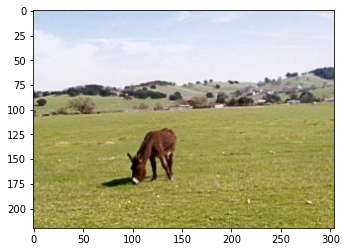

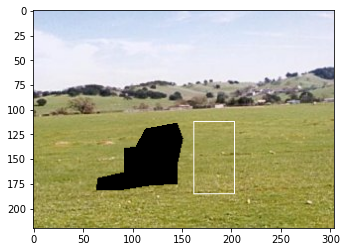

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  3473
Number of pixels remaining =  1146
Number of pixels remaining =  21


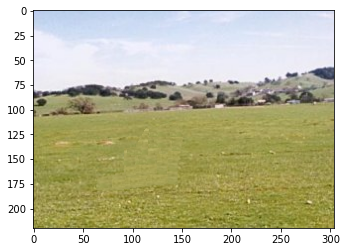

donkey


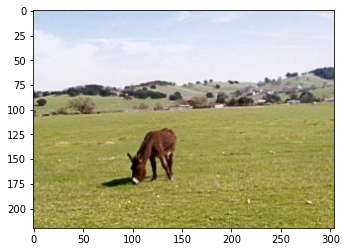

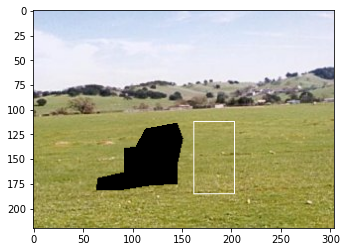

Are you happy with this choice of fillRegion and textureIm?
Yes or No: YEs


In [ ]:
%matplotlib inline
texture_synthesis("data/donkey.jpg", randomPatchSD=0, patchL=10)
texture_synthesis("data/donkey.jpg", randomPatchSD=2000, patchL=10)

### Question 6

Traceback (most recent call last):
  File "C:\Users\mrric\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "<ipython-input-5-510bc9623029>", line 43, in handle_close
    assert len(fillPolyPoint) >= 6, "A polygon requires at least 3 points"
AssertionError: A polygon requires at least 3 points
Traceback (most recent call last):
  File "C:\Users\mrric\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "<ipython-input-5-510bc9623029>", line 43, in handle_close
    assert len(fillPolyPoint) >= 6, "A polygon requires at least 3 points"
AssertionError: A polygon requires at least 3 points


Would you like to select the region to be filled (0) or the sample texture region (1)?
0 or 1: 0
Please use your mouse to specify the region that you want for data/fill_region_almafi.pkl
(Click to select each polygon vertex. Close the window to complete and save the polygon.)


<IPython.core.display.Javascript object>


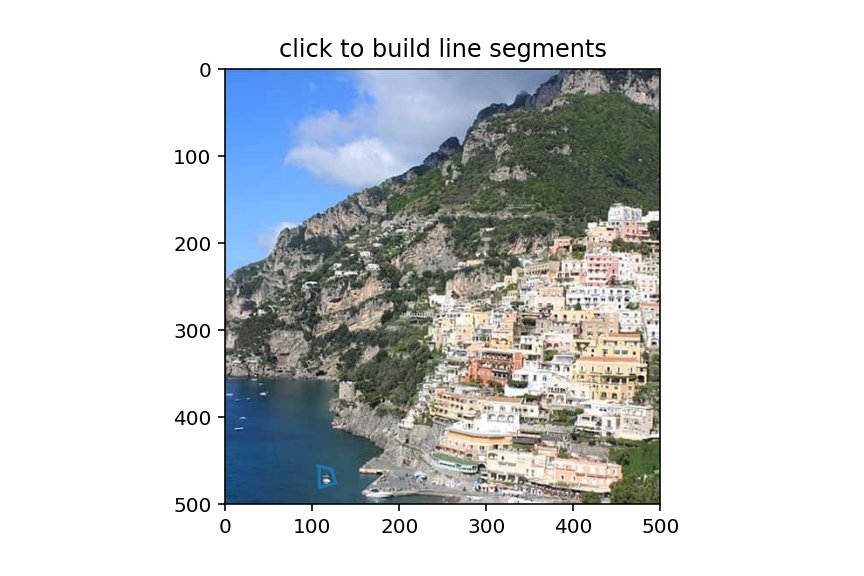

In [10]:
%matplotlib notebook
polyselect("data/almafi.jpg")

Would you like to select the region to be filled (0) or the sample texture region (1)?
0 or 1: 1
Note: Code in Holefill.py forces the texture region to be rectangular
Please use your mouse to specify the region that you want for data/texture_region_almafi.pkl
(Click to select each polygon vertex. Close the window to complete and save the polygon.)


<IPython.core.display.Javascript object>


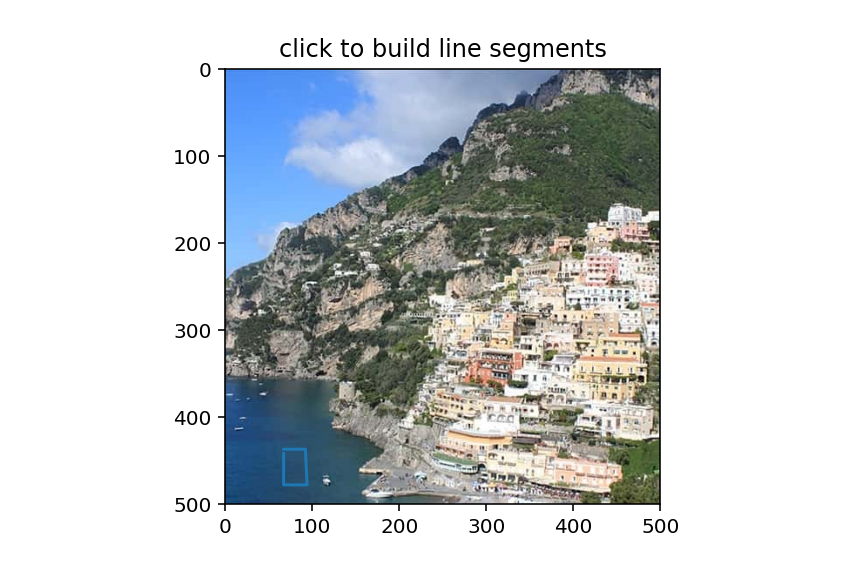

In [11]:
%matplotlib notebook
polyselect("data/almafi.jpg")

almafi


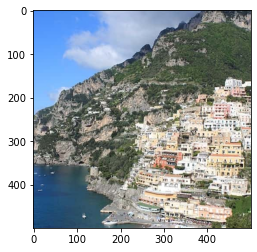

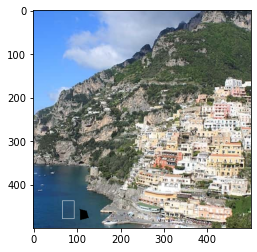

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  364


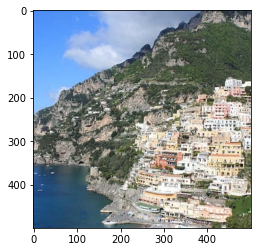

In [14]:
%matplotlib inline
texture_synthesis("data/almafi.jpg", randomPatchSD=1, patchL=10)

Would you like to select the region to be filled (0) or the sample texture region (1)?
0 or 1: 0
Please use your mouse to specify the region that you want for data/fill_region_crowd.pkl
(Click to select each polygon vertex. Close the window to complete and save the polygon.)


<IPython.core.display.Javascript object>


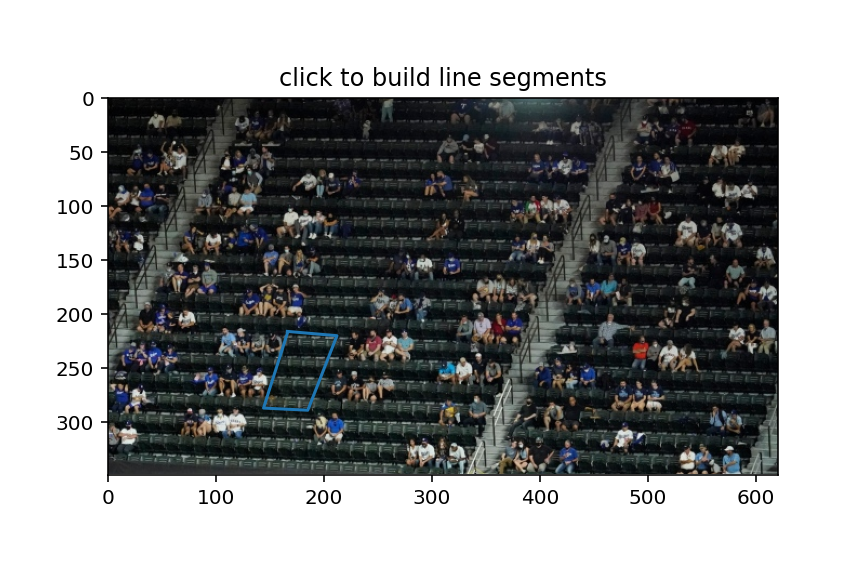

In [13]:
%matplotlib notebook
polyselect("data/crowd.jpg")

Would you like to select the region to be filled (0) or the sample texture region (1)?
0 or 1: 1
Note: Code in Holefill.py forces the texture region to be rectangular
Please use your mouse to specify the region that you want for data/texture_region_crowd.pkl
(Click to select each polygon vertex. Close the window to complete and save the polygon.)


<IPython.core.display.Javascript object>


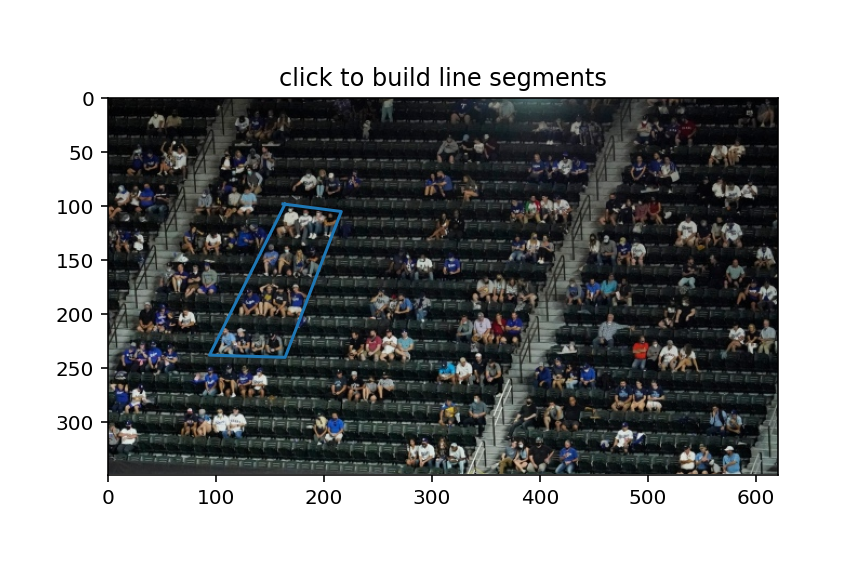

In [14]:
%matplotlib notebook
polyselect("data/crowd.jpg")

crowd


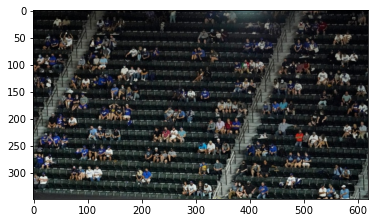

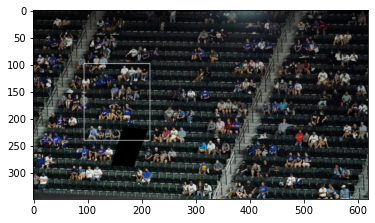

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  3169
Number of pixels remaining =  1037
Number of pixels remaining =  23


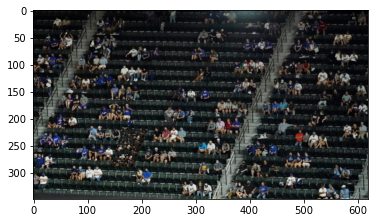

crowd


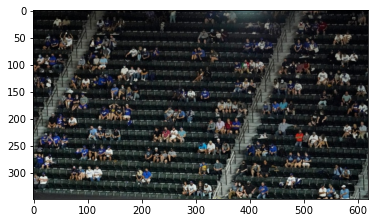

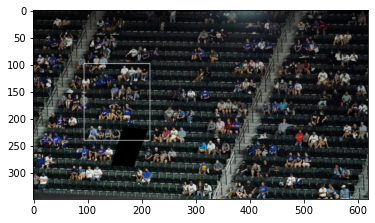

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  3169
Number of pixels remaining =  1045
Number of pixels remaining =  31


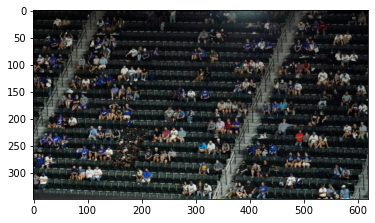

crowd


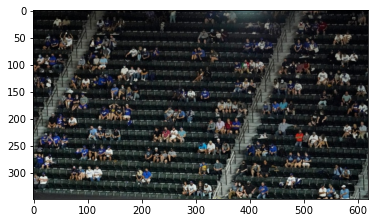

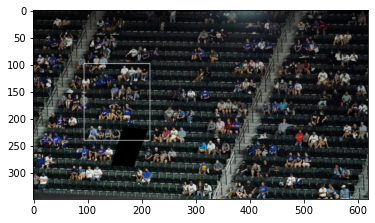

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  3169
Number of pixels remaining =  985


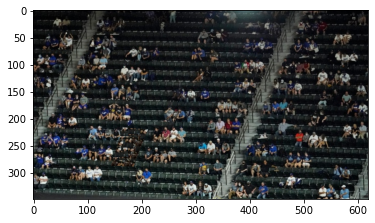

crowd


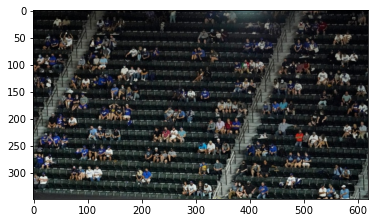

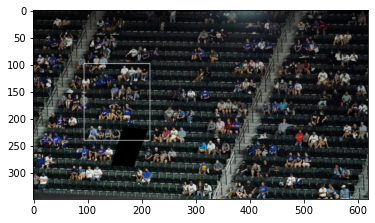

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  3169
Number of pixels remaining =  1026
Number of pixels remaining =  14


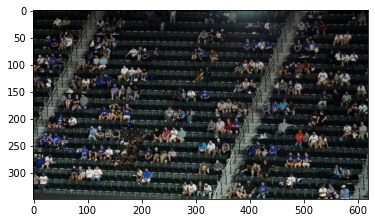

crowd


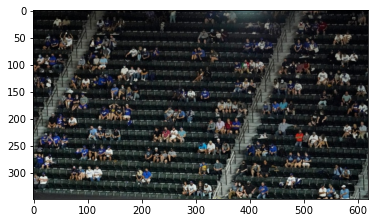

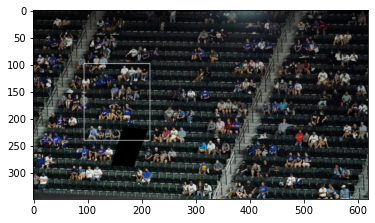

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  3169
Number of pixels remaining =  983
Number of pixels remaining =  6


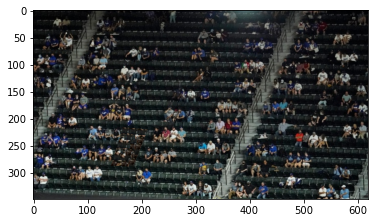

In [12]:
%matplotlib inline
texture_synthesis("data/crowd.jpg", randomPatchSD=0, patchL=10)
texture_synthesis("data/crowd.jpg", randomPatchSD=1, patchL=10)
texture_synthesis("data/crowd.jpg", randomPatchSD=5, patchL=10)
texture_synthesis("data/crowd.jpg", randomPatchSD=10, patchL=10)
texture_synthesis("data/crowd.jpg", randomPatchSD=20, patchL=10)

### Question 7
As the random patch standard deviation increases, the synthesized texture seems to blend more into the area being filled. This results in a